In [1]:
import os
import json
import datetime
from collections import Counter

import pandas as pd
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MaxNLocator, NullLocator

DATA_DIR = os.path.join("Data", "SARS-CoV-2_spike")
OUTPUT_DIR = os.path.join("Output", "ReverseMut")

In [2]:
plt.rcParams.update({'font.size': 20, 'font.weight': 'bold'})
fontsize = 20

In [3]:
mutSites = pd.read_csv(os.path.join("Data", "SARS-CoV-2_genome", "mutSites.csv"), index_col=0)
mutSites = mutSites[mutSites['Var1'].str.len() == 10]
mutSites['Var1'] = pd.to_datetime(mutSites['Var1'])
mutSites = mutSites[mutSites['Var1'] > datetime.datetime(2019, 11, 30)]
mutSites.set_index("Var1", inplace=True)

In [4]:
background = pd.read_csv(os.path.join("Data", "SARS-CoV-2_genome", "background.csv"), index_col=0)
background = background[background['Var1'].str.len() == 10]
background['Var1'] = pd.to_datetime(background['Var1'])
background = background[background['Var1'] > datetime.datetime(2019, 11, 30)]
background.set_index("Var1", inplace=True)

In [5]:
with open(os.path.join("Data", "SARS-CoV-2_genome", "parallelFirstDate.json")) as f:
    parallelFirstDate = json.load(f)

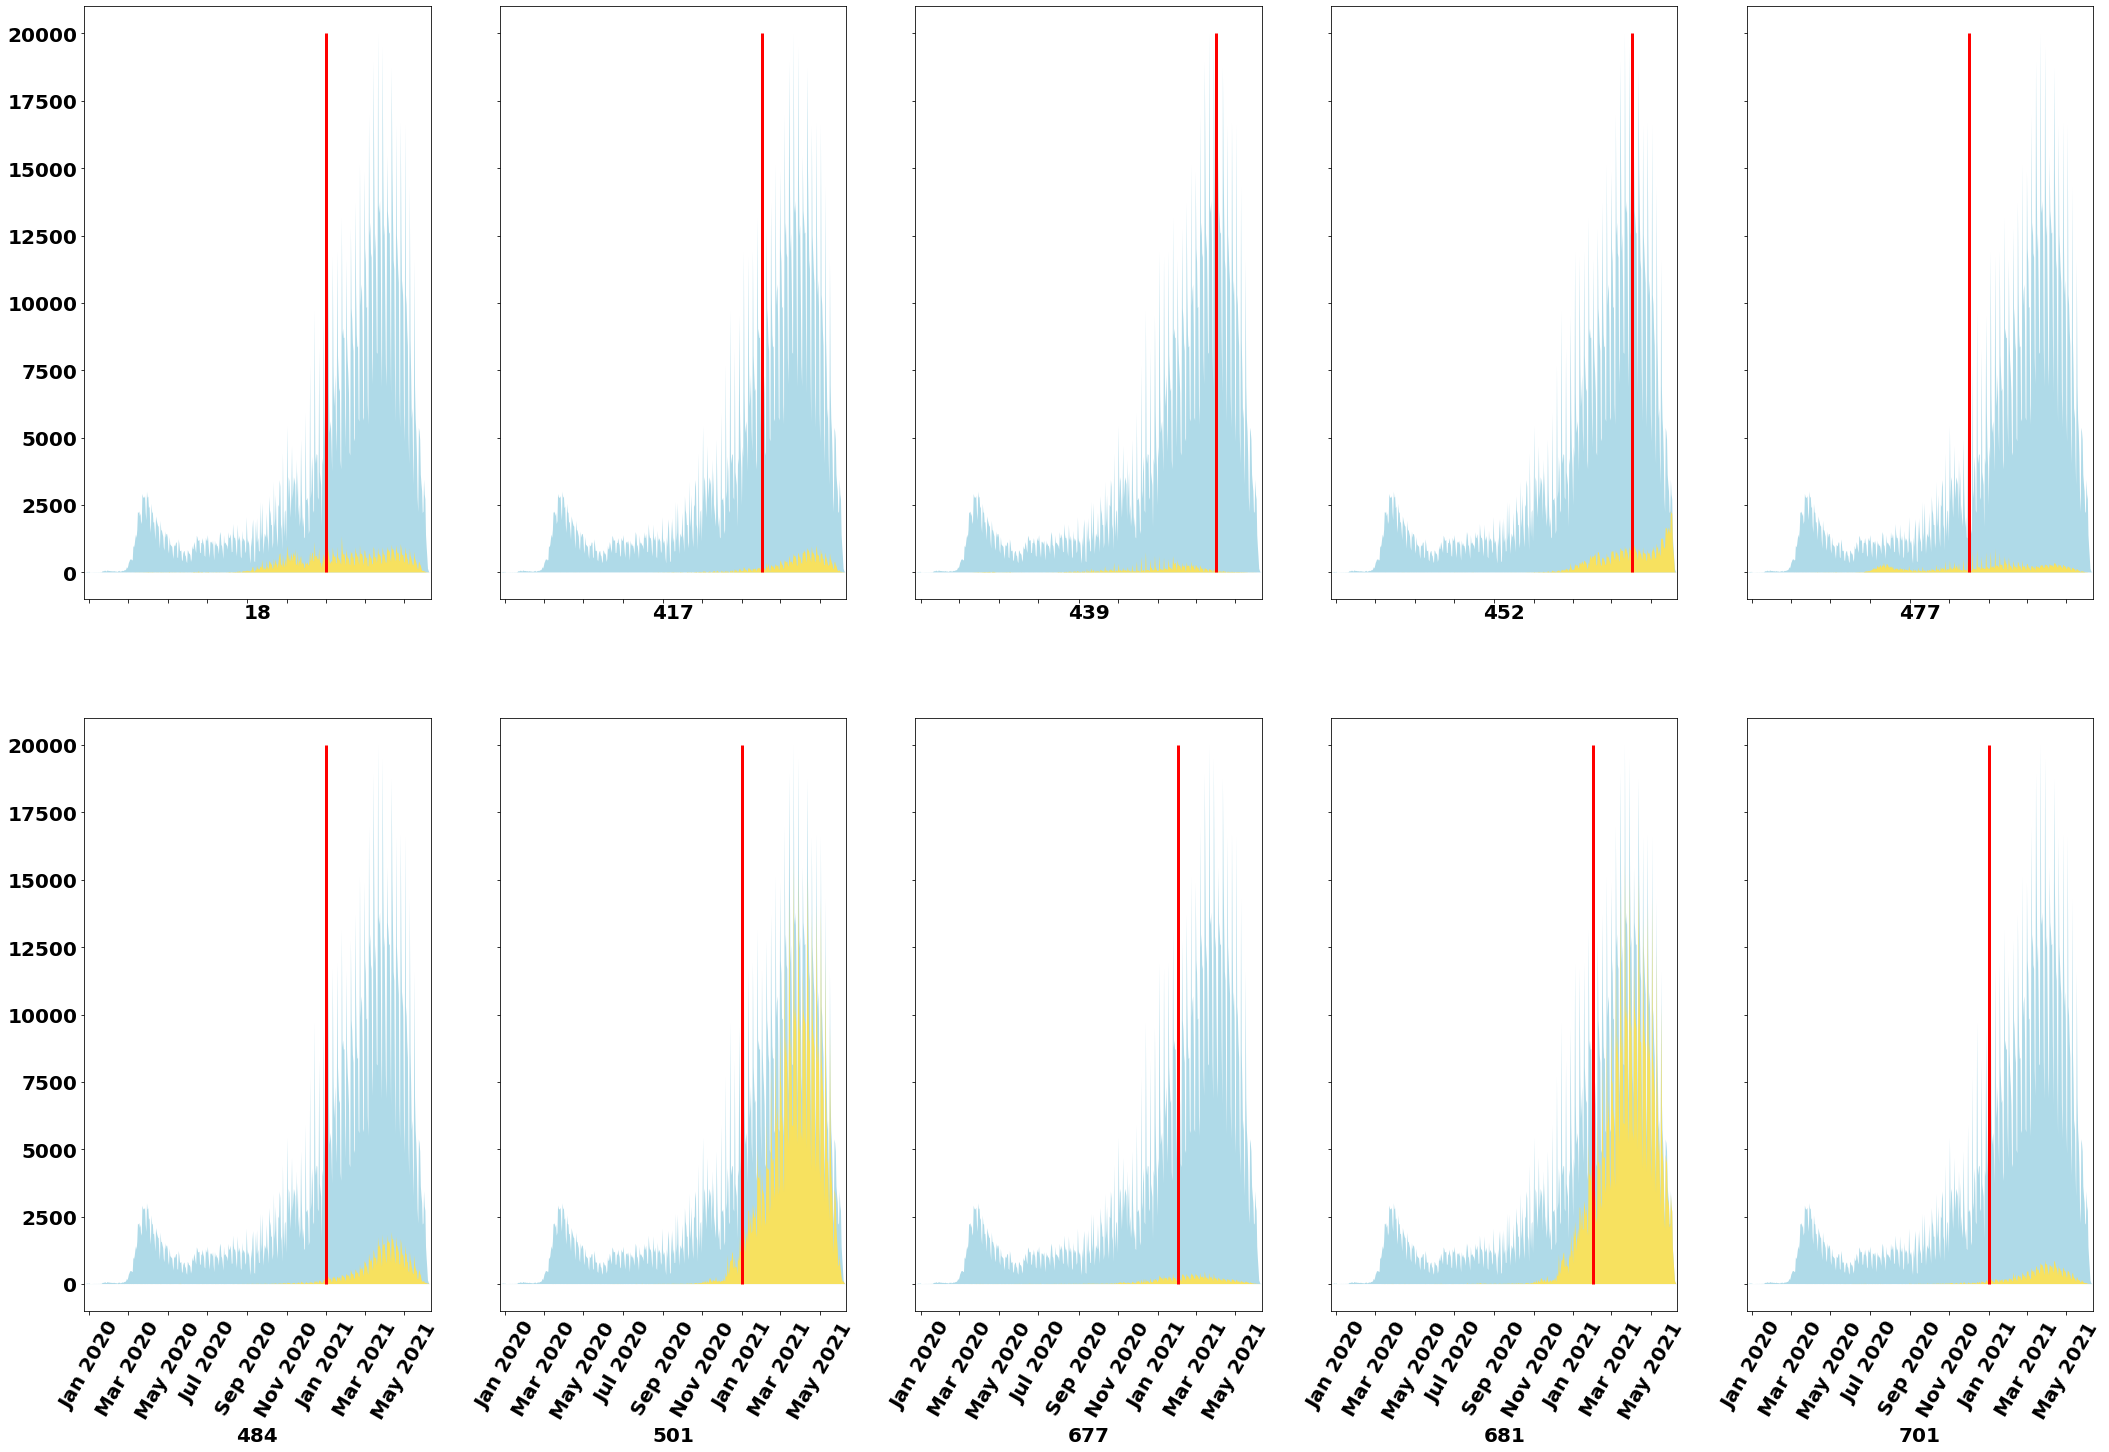

In [6]:
x_pos = background.index.unique()
x_pos.sort_values()
x_pos = pd.to_datetime(x_pos)

nrows = 2
ncols = 5

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    sharex=True,
    sharey=True,
    figsize = (3 * ncols * 2.4, 24)
)
axes2 = []
for ax in axes:
    axes2.extend(ax)

n = 0
for site, meta in mutSites.groupby("site"):
    mutNum = []
    bgNum = background['Freq'].values

    for d in x_pos:
        if d in meta.index:
            mutNum.append(meta.loc[d, "Freq"])
        else:
            mutNum.append(0)
    if str(site) in parallelFirstDate and site != 614:
        ax = axes2[n]
        n += 1
        ax.fill_between(x_pos, 0, bgNum, label = "Backgroup", facecolor='#AFDAE8')
        ax.fill_between(x_pos, 0, mutNum, label = "mutation", facecolor='#F7E15F')
        ax.vlines(x=parallelFirstDate[str(site)], colors="red", ymin=0, ymax=max(bgNum), linewidth=3)
        ax.tick_params(axis='x', labelrotation=60)
        ax.set_xlim([x_pos[1], x_pos[-1]])
        ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
        ax.set_xlabel(site, fontsize=fontsize, fontweight='bold')

plt.savefig(os.path.join("Output", "parallelSites.pdf"), bbox_inches="tight")
plt.show()

In [7]:
K417N_mut = pd.read_csv(os.path.join(DATA_DIR, "K417N_mut.csv"))
K417N_mut = K417N_mut[K417N_mut['Collection.date'].str.len() == 10]
K417N_mut['Collection.date'] = pd.to_datetime(K417N_mut['Collection.date'])
# K417N_mut = K417N_mut[K417N_mut['Collection.date'] < datetime.datetime(2000, 1, 1)]
K417N_mut['region'] = K417N_mut["Location"].str.split(' / ').str[0]

K417N_rev = pd.read_csv(os.path.join(DATA_DIR, "K417N_rev.csv"))
K417N_rev = K417N_rev[K417N_rev['Collection.date'].str.len() == 10]
K417N_rev['Collection.date'] = pd.to_datetime(K417N_rev['Collection.date'])
# K417N_rev = K417N_rev[K417N_rev['Collection.date'] < datetime.datetime(2000, 1, 1)]
K417N_rev['region'] = K417N_rev["Location"].str.split(' / ').str[0]

In [8]:
with open(os.path.join(DATA_DIR, "featureSNP.json")) as f:
    featureSNP = json.load(f)

In [9]:
# count = list()

# for row in K417N_mut[K417N_mut["Collection.date"] > datetime.datetime(2020, 11, 1)]["AA.Substitutions"]:
#     count.append(len(set(row.strip("()").split(",")).intersection(set(featureSNP["B.1.351"]))))

# Counter(count)

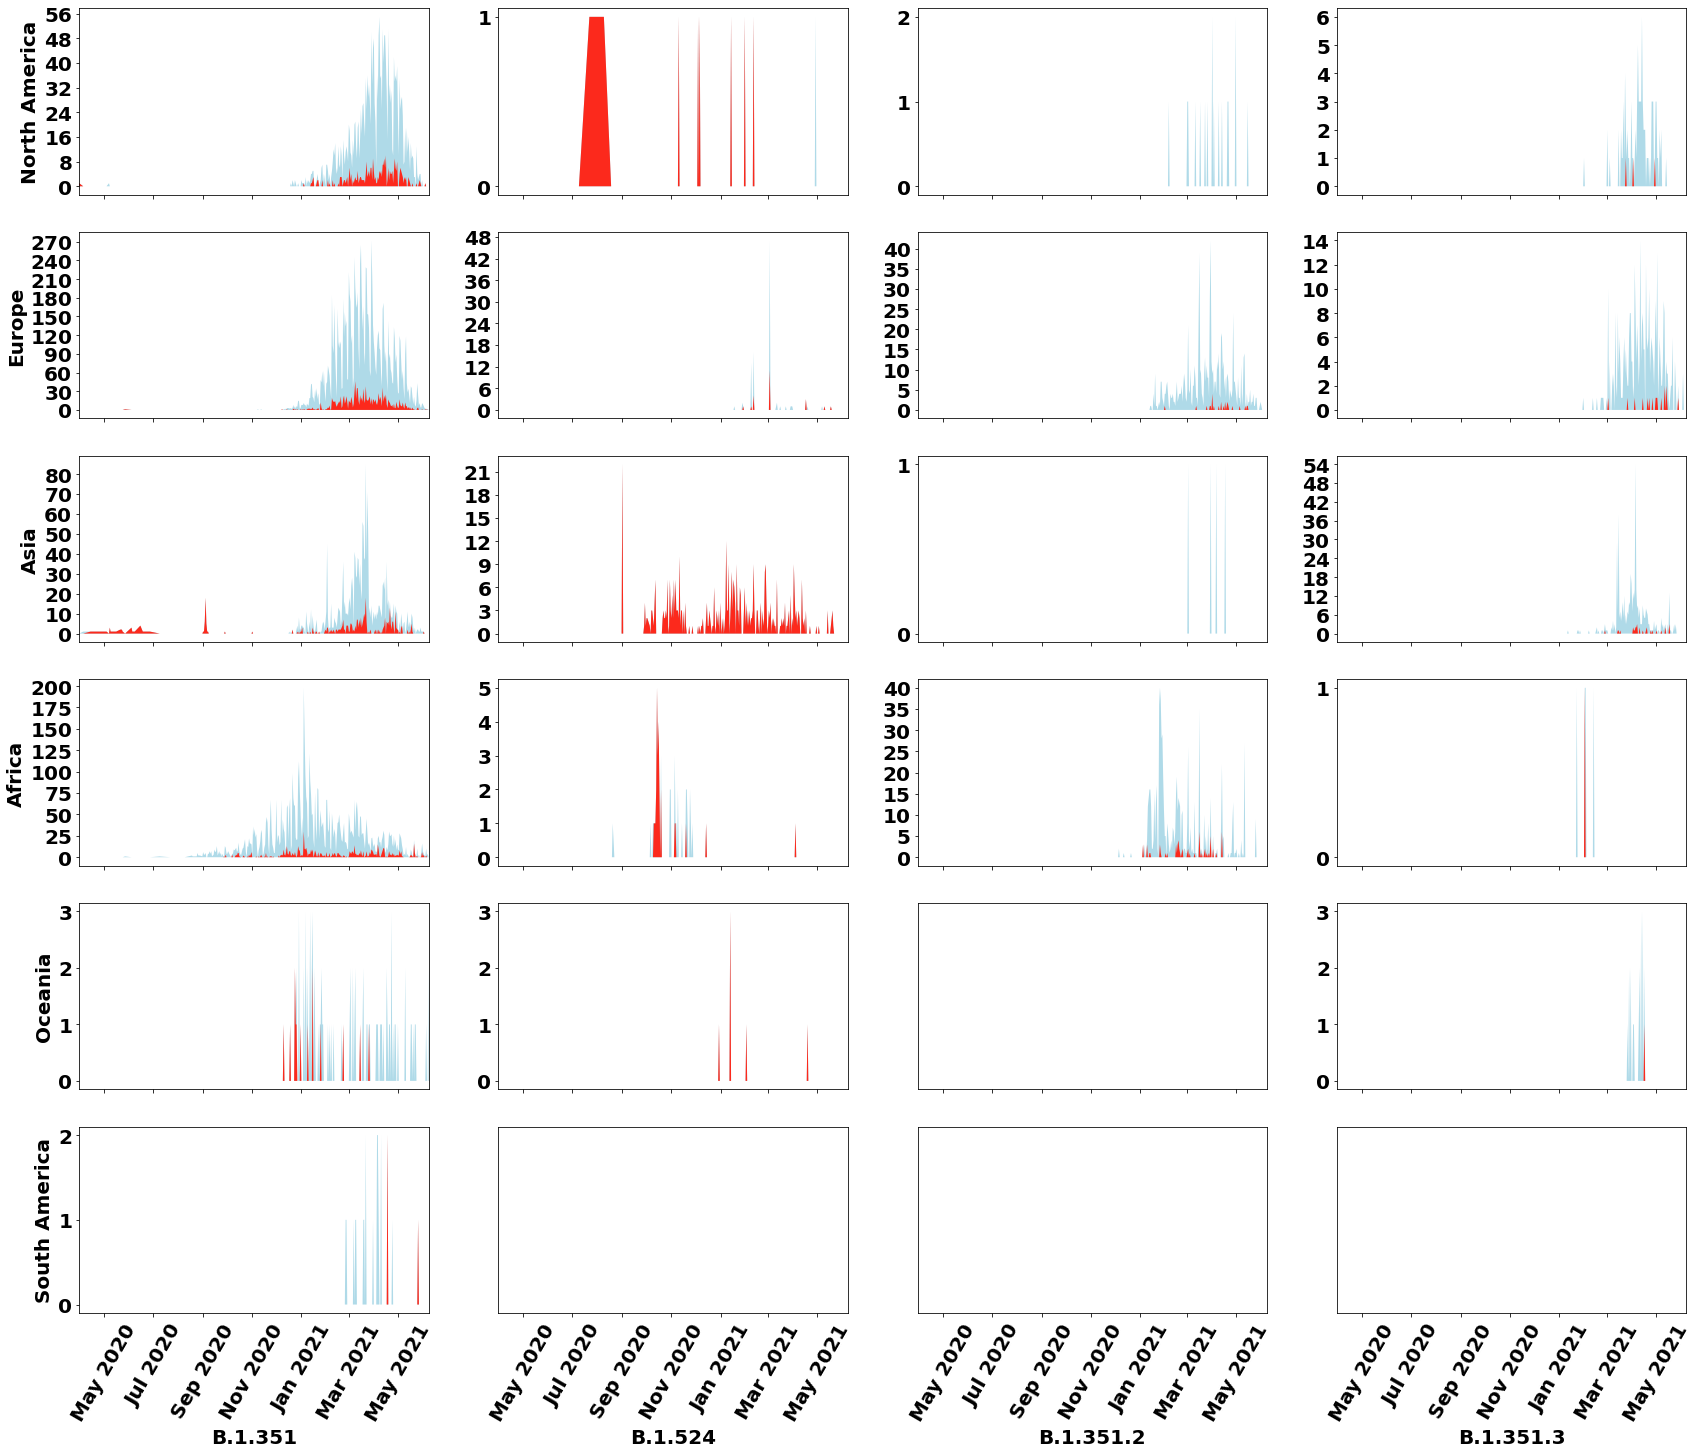

In [10]:
x_pos = pd.concat([K417N_rev['Collection.date'], K417N_mut['Collection.date']]).unique()
x_pos.sort()
x_pos = pd.to_datetime(x_pos)
x_pos = x_pos[x_pos > datetime.datetime(2019, 11, 30)]

lineages = pd.concat([K417N_rev["Pango.lineage"], K417N_mut["Pango.lineage"]]).unique()
regions = pd.concat([K417N_rev["region"], K417N_mut["region"]]).unique()

nlineages = len(lineages)
nregions = len(regions)

fig, axes = plt.subplots(
    nrows=nregions, 
    ncols=nlineages,
    sharex=True,
#     sharey="row",
    figsize = (3 * nlineages * 2.4, 24)
)

for i in range(nlineages):
    lineage = lineages[i]
    for j in range(nregions):
        region = regions[j]
        revInfo = K417N_rev.loc[(K417N_rev["Pango.lineage"] == lineage) & (K417N_rev["region"] == region), ]
        mutInfo = K417N_mut.loc[(K417N_mut["Pango.lineage"] == lineage) & (K417N_mut["region"] == region), ]

        rev = revInfo['Collection.date'].value_counts()
        mut = mutInfo['Collection.date'].value_counts()
        revNum = []
        mutNum = []
        bgNum = []
        
        for d in x_pos:
            if d in mut.index:
                mutNum.append(mut[d])
            else:
                mutNum.append(0)

            if d in rev.index:
                revNum.append(rev[d])
            else:
                revNum.append(0)

            bgNum.append(mutNum[-1] + revNum[-1])
        
        ax = axes[j][i]
        ax.fill_between(x_pos, 0, bgNum, label = "Backgroup", facecolor='#AFDAE8')
        ax.fill_between(x_pos, 0, revNum, label = "N417K", facecolor='#FC291C')
        ax.tick_params(axis='x', labelrotation=60)
        ax.set_xlim([x_pos[1], x_pos[-1]])
        ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
        if sum(bgNum):
            ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune="both"))
        else:
            ax.yaxis.set_major_locator(NullLocator())
        if j == nregions - 1:
            ax.set_xlabel(lineage, fontsize=fontsize, fontweight='bold')
        if i == 0:
            ax.set_ylabel(region, fontsize=fontsize, fontweight='bold')

plt.savefig(os.path.join(OUTPUT_DIR, "K417N.pdf"), bbox_inches="tight")
plt.show()

In [11]:
K417T_mut = pd.read_csv(os.path.join(DATA_DIR, "K417T_mut.csv"))
K417T_mut = K417T_mut[K417T_mut['Collection.date'].str.len() == 10]
K417T_mut['Collection.date'] = pd.to_datetime(K417T_mut['Collection.date'])
# K417T_mut = K417T_mut[K417T_mut['Collection.date'] < datetime.datetime(2000, 1, 1)]
K417T_mut['region'] = K417T_mut["Location"].str.split(' / ').str[0]

K417T_rev = pd.read_csv(os.path.join(DATA_DIR, "K417T_rev.csv"))
K417T_rev = K417T_rev[K417T_rev['Collection.date'].str.len() == 10]
K417T_rev['Collection.date'] = pd.to_datetime(K417T_rev['Collection.date'])
# K417T_rev = K417T_mut[K417T_rev['Collection.date'] < datetime.datetime(2000, 1, 1)]
K417T_rev['region'] = K417T_rev["Location"].str.split(' / ').str[0]

In [12]:
count = list()

for row in K417N_rev[K417N_rev["Collection.date"] < datetime.datetime(2021, 2, 1)]["AA.Substitutions"]:
    count.append(len(set(row.strip("()").split(",")).intersection(set(featureSNP["P.1"]))))
    
Counter(count)

Counter({2: 374, 1: 98, 7: 85, 4: 97, 5: 144, 6: 14, 8: 17, 9: 4, 3: 1, 0: 4})

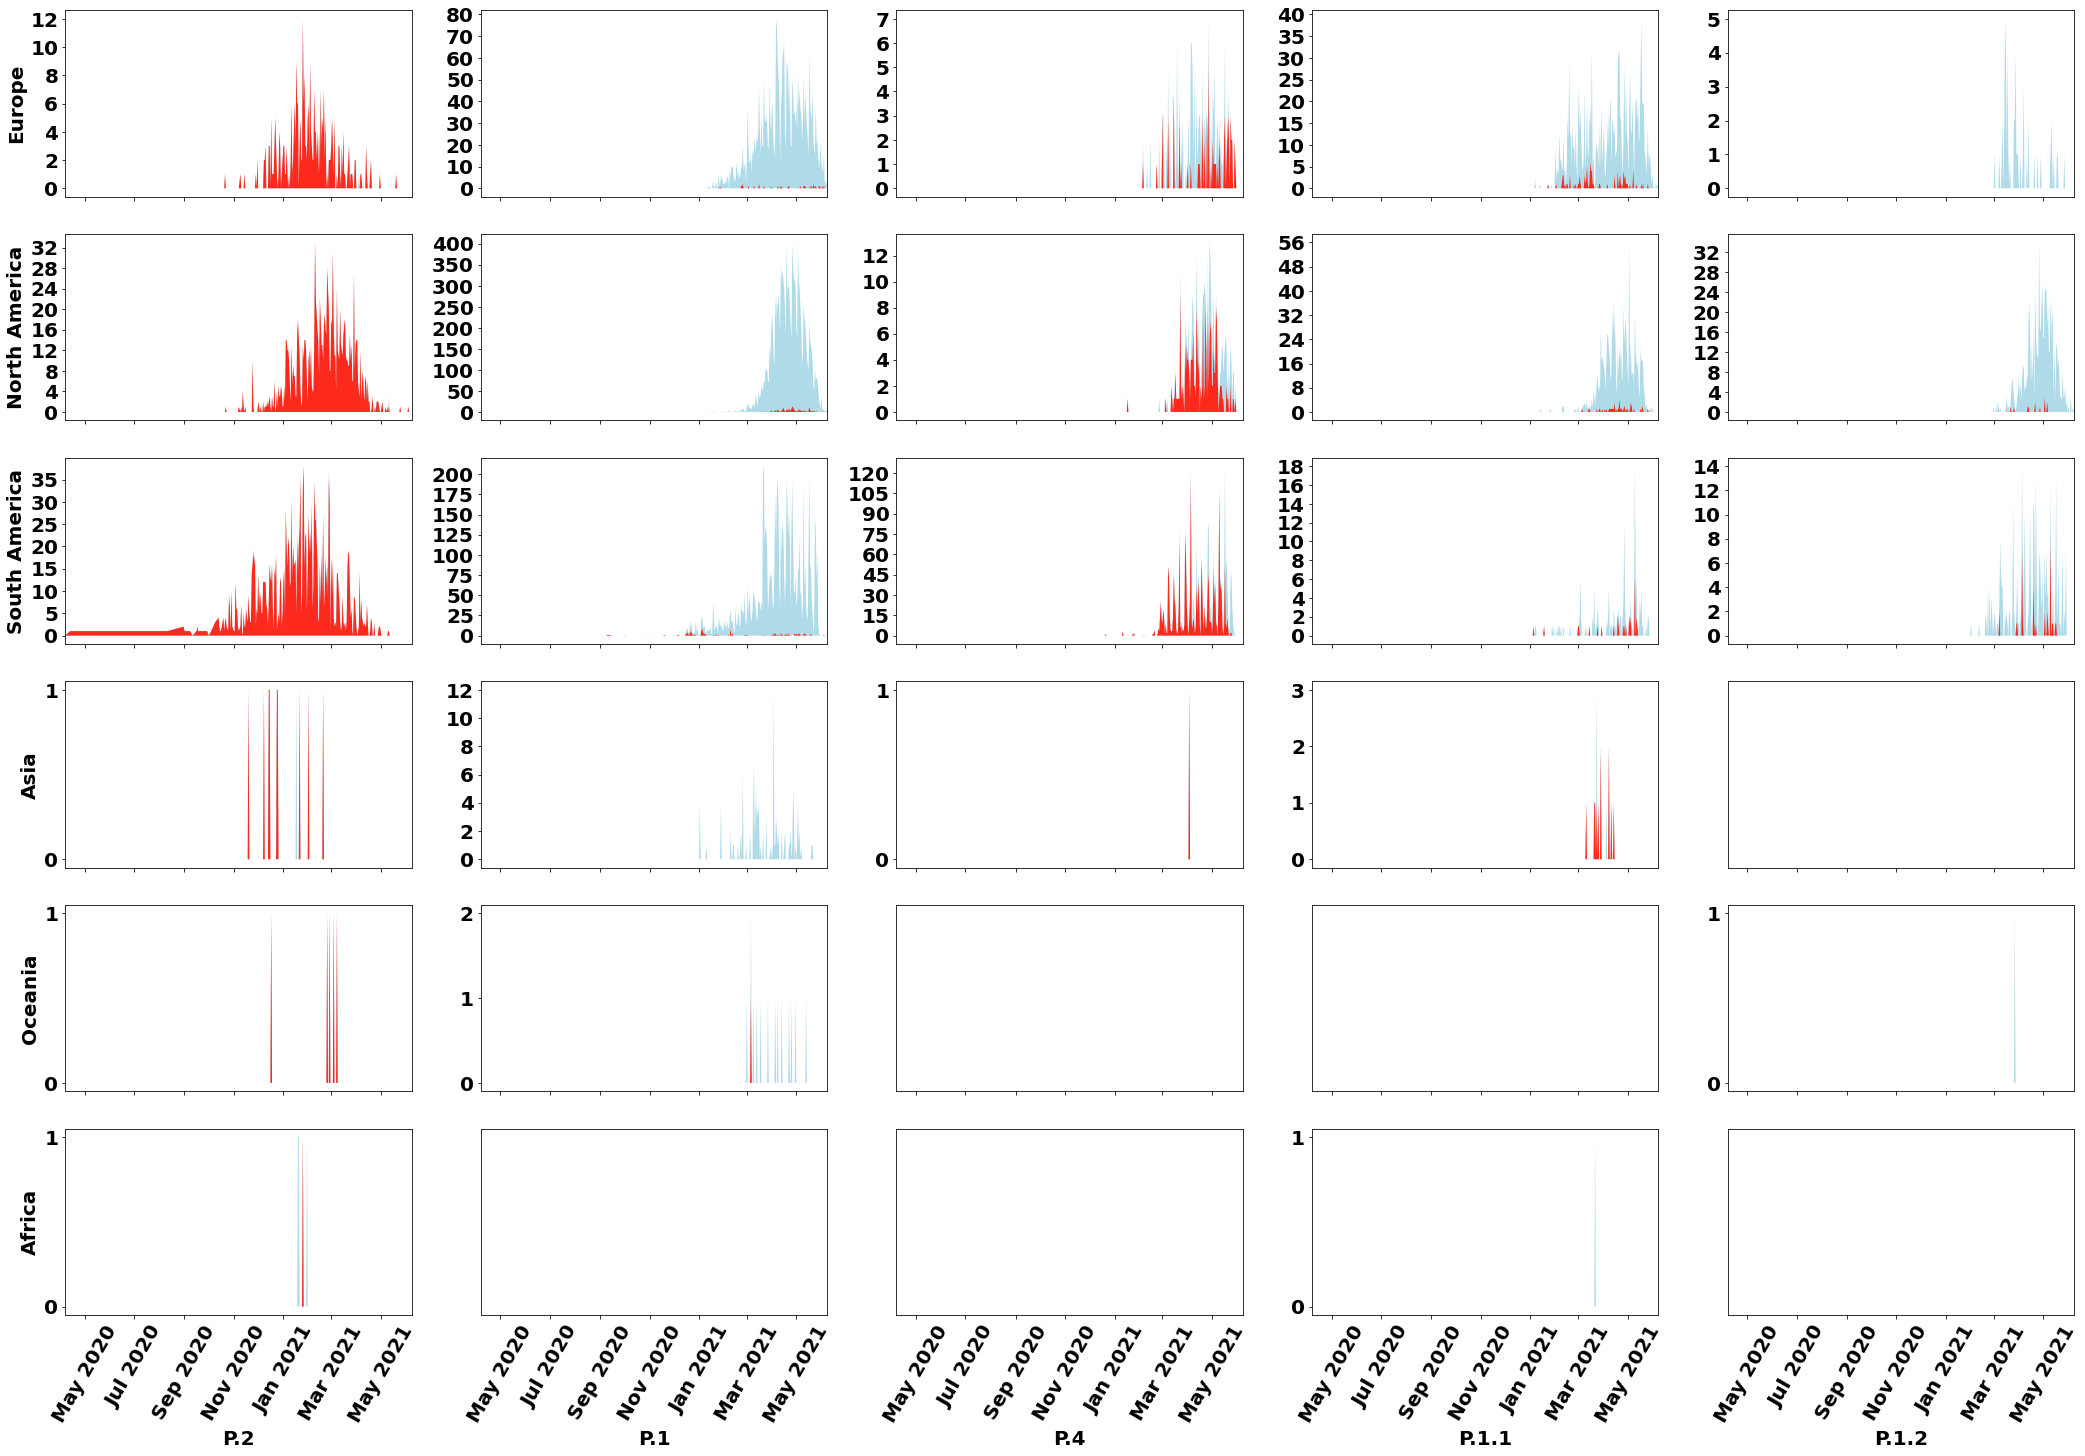

In [13]:
x_pos = pd.concat([K417T_rev['Collection.date'], K417T_mut['Collection.date']]).unique()
x_pos.sort()
x_pos = pd.to_datetime(x_pos)
x_pos = x_pos[x_pos > datetime.datetime(2019, 11, 30)]

lineages = pd.concat([K417T_rev["Pango.lineage"], K417T_mut["Pango.lineage"]]).unique()
regions = pd.concat([K417T_rev["region"], K417T_mut["region"]]).unique()

nlineages = len(lineages)
nregions = len(regions)

fig, axes = plt.subplots(
    nrows=nregions, 
    ncols=nlineages,
    sharex=True,
#     sharey="row",
    figsize = (3 * nlineages * 2.4, 24)
)

for i in range(nlineages):
    lineage = lineages[i]
    for j in range(nregions):
        region = regions[j]
        revInfo = K417T_rev.loc[(K417T_rev["Pango.lineage"] == lineage) & (K417T_rev["region"] == region), ]
        mutInfo = K417T_mut.loc[(K417T_mut["Pango.lineage"] == lineage) & (K417T_mut["region"] == region), ]

        rev = revInfo['Collection.date'].value_counts()
        mut = mutInfo['Collection.date'].value_counts()
        revNum = []
        mutNum = []
        bgNum = []
        
        for d in x_pos:
            if d in mut.index:
                mutNum.append(mut[d])
            else:
                mutNum.append(0)

            if d in rev.index:
                revNum.append(rev[d])
            else:
                revNum.append(0)

            bgNum.append(mutNum[-1] + revNum[-1])
        
        ax = axes[j][i]
        ax.fill_between(x_pos, 0, bgNum, label = "P.4", facecolor='#AFDAE8')
        ax.fill_between(x_pos, 0, revNum, label = "T417K", facecolor='#FC291C')
        ax.tick_params(axis='x', labelrotation=60)
        ax.set_xlim([x_pos[1], x_pos[-1]])
        ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
        if sum(bgNum):
            ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune="both"))
        else:
            ax.yaxis.set_major_locator(NullLocator())
        if j == nregions - 1:
            ax.set_xlabel(lineage, fontsize=fontsize, fontweight='bold')
        if i == 0:
            ax.set_ylabel(region, fontsize=fontsize, fontweight='bold')

plt.savefig(os.path.join(OUTPUT_DIR, "K417T.pdf"), bbox_inches="tight")
plt.show()